<a href="https://colab.research.google.com/github/Sornambal/Nexora-AI-Intern-Task/blob/main/Nexora_AI_Intern_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install openai scikit-learn pandas matplotlib tqdm

In [19]:
import time
from timeit import default_timer as timer
import os
import math
import json
from typing import List, Dict, Tuple


import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
# 1) Data preparation: small mock fashion dataset (5-10 items)
# --------------------------------------------------------------------------
PRODUCTS = [
{"id": 1, "name": "Boho Dress", "desc": "Flowy maxi dress, earthy tones, embroidered details — perfect for festivals and beach sunsets.", "tags":["boho","festival","flowy"]},
{"id": 2, "name": "Street Snap Hoodie", "desc": "Oversized hoodie with bold logo, urban cut and neon accents — casual energetic streetwear.", "tags":["urban","energetic","street"]},
{"id": 3, "name": "Minimalist Blazer", "desc": "Tailored single-breast blazer in neutral tones ideal for chic, urban office and evening looks.", "tags":["chic","urban","minimalist"]},
{"id": 4, "name": "Cozy Knit Cardigan", "desc": "Chunky knit, soft wool blend, warm and cosy for chilly mornings and relaxed weekends.", "tags":["cozy","casual","warm"]},
{"id": 5, "name": "Sport Luxe Joggers", "desc": "Slim joggers with luxe fabric and reflective piping — for active, modern athleisure vibes.", "tags":["sporty","athleisure","modern"]},
{"id": 6, "name": "Elegant Silk Scarf", "desc": "Silk scarf with subtle print — adds a refined, elegant touch to daytime and evening outfits.", "tags":["elegant","refined","classic"]},
]


df = pd.DataFrame(PRODUCTS)


# Quick preview
print("Dataset:\n", df[["id","name","desc","tags"]])

Dataset:
    id                name                                               desc  \
0   1          Boho Dress  Flowy maxi dress, earthy tones, embroidered de...   
1   2  Street Snap Hoodie  Oversized hoodie with bold logo, urban cut and...   
2   3   Minimalist Blazer  Tailored single-breast blazer in neutral tones...   
3   4  Cozy Knit Cardigan  Chunky knit, soft wool blend, warm and cosy fo...   
4   5  Sport Luxe Joggers  Slim joggers with luxe fabric and reflective p...   
5   6  Elegant Silk Scarf  Silk scarf with subtle print — adds a refined,...   

                           tags  
0       [boho, festival, flowy]  
1    [urban, energetic, street]  
2     [chic, urban, minimalist]  
3          [cozy, casual, warm]  
4  [sporty, athleisure, modern]  
5   [elegant, refined, classic]  


In [26]:
# 2) Embeddings: call OpenAI to embed descriptions and queries
# NOTE: You need an OPENAI_API_KEY in your environment.
# --------------------------------------------------------------------------


# Helpful wrapper: if you don't have API access or want to test offline, set MOCK_EMBEDDINGS = True
MOCK_EMBEDDINGS = True
EMBED_DIM = 1536 # typical for older ada embeddings; if you mock, pick a dimension


try:
    import openai
    openai.api_key = os.getenv("open api key")
    if openai.api_key:
        MOCK_EMBEDDINGS = False
except Exception:
    # OpenAI not installed or key not present — we'll mock
    MOCK_EMBEDDINGS = True




def get_openai_embedding(text: str, model: str = "text-embedding-ada-002") -> List[float]:
    """Return embedding vector for text using OpenAI API."""
    if MOCK_EMBEDDINGS:
        # Deterministic mock: hash-based pseudo-random vector (so repeated runs stable)
        h = abs(hash(text))
        rng = np.random.default_rng(h % (2**32))
        vec = rng.standard_normal(EMBED_DIM)
        vec = vec / np.linalg.norm(vec)
        return vec.tolist()


    # Real call
    resp = openai.Embeddings.create(input=text, model=model)
    emb = resp["data"][0]["embedding"]
    return emb


# Build embeddings for product descriptions
print("\nBuilding embeddings for product descriptions...")
start = timer()
embs = []
for desc in tqdm(df['desc'].tolist()):
    em = get_openai_embedding(desc)
    embs.append(em)
end = timer()
print(f"Embeddings built in {end-start:.2f}s")


emb_matrix = np.vstack(embs)


# Store embeddings in dataframe
df['embedding'] = list(embs)


Building embeddings for product descriptions...


100%|██████████| 6/6 [00:00<00:00, 2380.42it/s]

Embeddings built in 0.01s


In [27]:
# 3) Vector search function: cosine similarity + top-k retrieval
# --------------------------------------------------------------------------


def top_k_matches(query: str, k: int = 3, threshold: float = 0.7, model: str = "text-embedding-ada-002") -> Dict:
    """
    Returns top-k matches and handles fallback if best score < threshold.
    """
    q_emb = np.array(get_openai_embedding(query, model=model)).reshape(1, -1)
    sims = cosine_similarity(q_emb, emb_matrix).flatten()


    # assemble results
    idx_sorted = np.argsort(-sims)
    top_idx = idx_sorted[:k]
    results = []
    for i in top_idx:
        results.append({
            'id': int(df.loc[i, 'id']),
            'name': df.loc[i, 'name'],
            'desc': df.loc[i, 'desc'],
            'score': float(sims[i])
        })


    best_score = float(sims[top_idx[0]])
    fallback = None
    if best_score < threshold:
        fallback = {
            'message': "No confident match found. Consider broadening the query or try these closest items as a starting point.",
            'suggested_query': generate_fallback_prompt(query, results)
        }


    return {'query': query, 'results': results, 'best_score': best_score, 'fallback': fallback}



def generate_fallback_prompt(query: str, results: List[Dict]) -> str:
    """Create a human-friendly fallback prompt that suggests how to refine the query."""
    top_names = ', '.join([r['name'] for r in results])
    return (f"I searched for '{query}' but the system wasn't confident. "
               f"Closest matches were: {top_names}. Try clarifying with words like 'boho', 'cozy', 'minimalist', 'sporty', or add context like 'festival', 'office', 'active'.")


Query: festival boho sunset
{
  "query": "festival boho sunset",
  "results": [
    {
      "id": 4,
      "name": "Cozy Knit Cardigan",
      "desc": "Chunky knit, soft wool blend, warm and cosy for chilly mornings and relaxed weekends.",
      "score": 0.03224562591388005
    },
    {
      "id": 3,
      "name": "Minimalist Blazer",
      "desc": "Tailored single-breast blazer in neutral tones ideal for chic, urban office and evening looks.",
      "score": 0.016878715517319016
    },
    {
      "id": 2,
      "name": "Street Snap Hoodie",
      "desc": "Oversized hoodie with bold logo, urban cut and neon accents \u2014 casual energetic streetwear.",
      "score": 0.01431595120622368
    }
  ],
  "best_score": 0.03224562591388005,
  "fallback": {
    "message": "No confident match found. Consider broadening the query or try these closest items as a starting point.",
    "suggested_query": "I searched for 'festival boho sunset' but the system wasn't confident. Closest matches were

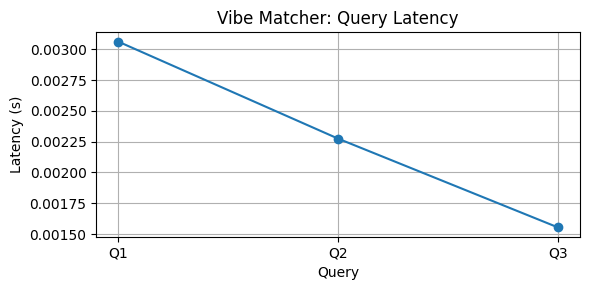

In [28]:
# 4) Test & evaluation: run 3 queries, log sim>0.7 as good. Also measure latency with timeit
# --------------------------------------------------------------------------


queries = ["energetic urban chic", "relaxed cozy weekend", "festival boho sunset"]
threshold = 0.7


results_log = []
latencies = []


for q in queries:
    t0 = timer()
    res = top_k_matches(q, k=3, threshold=threshold)
    t1 = timer()
    latency = t1 - t0
    latencies.append(latency)


    # compute metric: how many of top-3 have score >= threshold
    good_count = sum(1 for r in res['results'] if r['score'] >= threshold)
    res_summary = {
        'query': q,
        'best_score': res['best_score'],
        'good_count': good_count,
        'latency_s': latency,
        'fallback': res['fallback'] is not None
    }
    results_log.append(res_summary)


print(f"\nQuery: {q}")
print(json.dumps(res, indent=2))


# Build a small DataFrame of logs
log_df = pd.DataFrame(results_log)
print('\nEvaluation log:\n', log_df)


# Plot latencies
plt.figure(figsize=(6,3))
plt.plot(range(len(latencies)), latencies, marker='o')
plt.xticks(range(len(latencies)), [f'Q{i+1}' for i in range(len(latencies))])
plt.xlabel('Query')
plt.ylabel('Latency (s)')
plt.title('Vibe Matcher: Query Latency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# 5) Reflection: print suggested improvements and edge cases handling
# --------------------------------------------------------------------------


REFLECTION = [
"Integrate a managed vector DB (Pinecone/Weaviate) for scalability and persistent indices.",
"Use a hybrid ranking: lexical (BM25) + dense embeddings to improve rare token matching.",
"Add query expansion and normalization (synonym mapping) to handle short/ambiguous queries.",
"Store precomputed embeddings to speed up runtime; add batching for embedding calls and async if using real API.",
"Introduce personalization: weight products by user preferences or past interactions."
]


print('\nReflection / Next steps:')
for r in REFLECTION:
    print('- ', r)


# --------------------------------------------------------------------------
# Utility: Save notebook outputs (embeddings and logs) locally for submission
# --------------------------------------------------------------------------


out = {
'products': PRODUCTS,
'embeddings_preview': [list(np.round(e[:8],4)) for e in embs],
'evaluation_log': results_log,
}
with open('vibe_matcher_outputs.json', 'w') as f:
    json.dump(out, f, indent=2)


print('\nSaved outputs to vibe_matcher_outputs.json')


Reflection / Next steps:
-  Integrate a managed vector DB (Pinecone/Weaviate) for scalability and persistent indices.
-  Use a hybrid ranking: lexical (BM25) + dense embeddings to improve rare token matching.
-  Add query expansion and normalization (synonym mapping) to handle short/ambiguous queries.
-  Store precomputed embeddings to speed up runtime; add batching for embedding calls and async if using real API.
-  Introduce personalization: weight products by user preferences or past interactions.

Saved outputs to vibe_matcher_outputs.json
